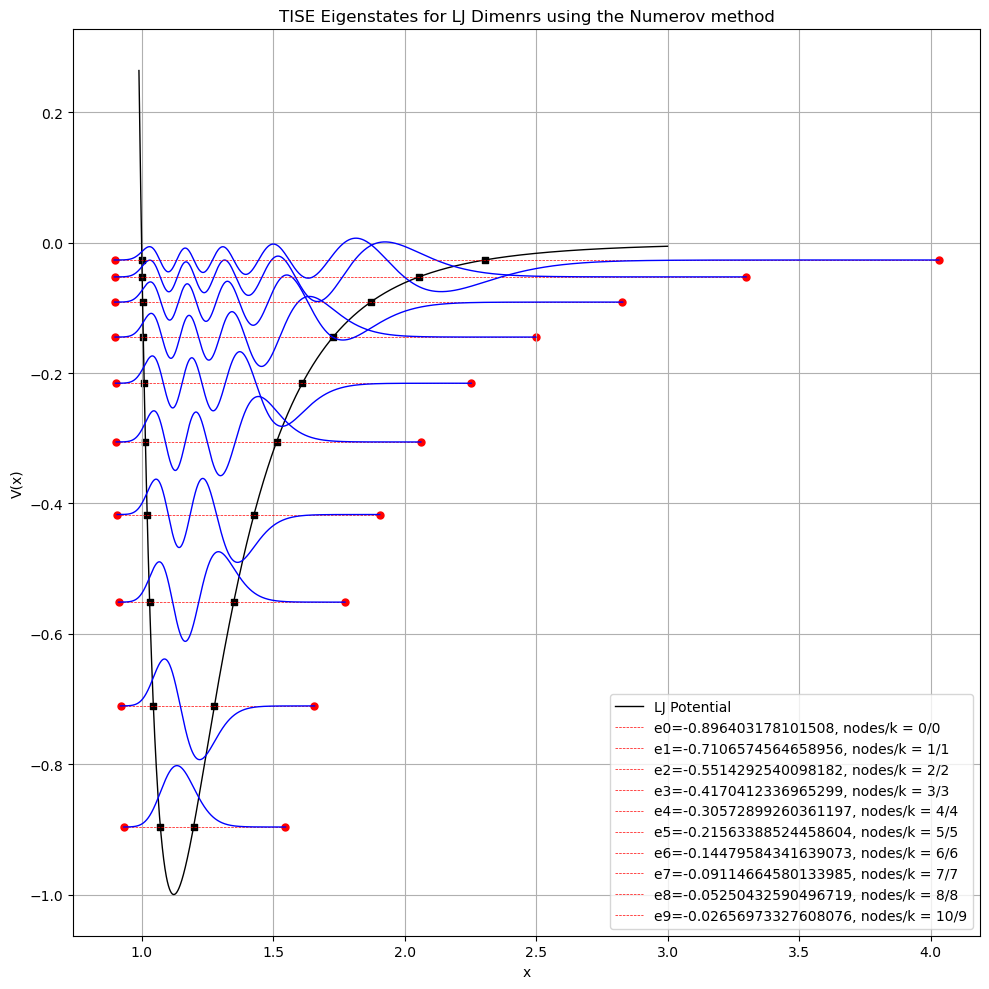

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

gamma = 50
alpha = 1e6

# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

# internal part of the Schrodinger eqn, in the Numerov general form y"(t) = g(t)y
# defined for the calculation of the CTPs, and integration limits 
# abs needed as sqrt(g) is calculated for these
def g(x, ek):
    return gamma**2 * abs(v(x) - ek)

def returnCTPs(ek):
    #Calculating the CTPs, root_scalar returns object with execulation results, unpacking needed for actual root
    ctp_left = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.0, x1=1.0 + 1e-4)
    ctp_right = root_scalar(lambda x: v(x)-ek, method='secant', x0=1.25, x1=1.25 + 1e-4)

    xa = ctp_left.root
    xb = ctp_right.root
    
    return xa,xb

def return_limits_for_E(ek):
    xa, xb = returnCTPs(ek)
    
    xs = root_scalar(
            lambda x: np.sqrt(g(x,ek)) * (xa - x) - np.log(alpha),
            bracket=[0.1,3],
            method='bisect',
        )
        # applying the same for end limit
        # func: sqrt{g(xe)} (xe-xb) ln A
    xe = root_scalar(
            lambda x: np.sqrt(g(x, ek)) * (x - xb) - np.log(alpha),
            bracket=[0.1,10],
            method='bisect',
        )
    xs = xs.root #unpacking the root_scalar object
    xe = xe.root
    return xs,xe

# Re-implement the refined explicit Numerov propagator
# re configured the numerov func for SE 
def numerov_for_SE(func,phi0, phi1, h, t):
    """
    Refined explicit Numerov propagator for solving y''(t) = g(t)y(t).
    
    Parameters:
    - func: The function g(t), such that y''(t) = g(t)y(t).
    - y0: Initial condition y(t0).
    - v0: Initial velocity y'(t0).
    - h: Step size for the numerical method.
    - t: Array of time points.
    
    Returns:
    - y: Array of dependent variable values computed using the explicit Numerov method.
    """
    y = np.zeros_like(t)
    
    y[0] = phi0 # two start points, as indicated by the setup
    y[1] = phi1  

    for n in range(1, len(t) - 1):
        # Compute coefficients a, b, c
        g_n = func(t[n])
        g_n_minus_1 = func(t[n - 1])
        g_n_plus_1 = func(t[n + 1])

        a = 2 + (5 / 6) * g_n * h**2
        b = 1 - (1 / 12) * g_n_minus_1 * h**2
        c = 1 - (1 / 12) * g_n_plus_1 * h**2

        # Update y[n+1] explicitly
        y[n + 1] = (a * y[n] - b * y[n - 1]) / c

    return y

# redefined, as the sign is very important for the calculation of the oscillatory and decaying parts
def g_for_SE(x,ek):
    return gamma**2 * (v(x) - ek)
    
# MAIN CALCULATIONS START HERE

# # defining the x-grid
dx = 0.001 
x = np.arange(0.99, 3, dx)
vx = [v(i) for i in x ]

# plotting the lennard jones potential, each of the energy levels and eigenstates to be plotted on the same graph inside the loop
plt.figure(figsize=(10, 10))
plt.plot(x, vx,color='k', label="LJ Potential", linewidth = 1)
plt.xlabel("x")
plt.ylabel("V(x)")

data = []

state = before_norm = after_norm = norm = 0 # accumulators, to be printed later

# k, determines the order of the solution
for k in range(0,9+1):
    
    iter = 1
    # k = 0, taken from the loop

    e_upper = 0 # bisection limits
    e_lower = -1.0

    phi_x_e_prev = 0 # for comparison, follows below

    while iter <= 100:
        e_mid = (e_upper + e_lower)/2
        
        
        # making calculations for current value of e_mid
        xs, xe = return_limits_for_E(e_mid)
        # dx declared above
        x_range = np.arange(xs-dx, xe+dx, dx)
        phi = numerov_for_SE(
            lambda x: g_for_SE(x,e_mid),
            phi0 = 0,
            phi1 = 1,
            h=dx,
            t=x_range
        )
        
        # calculating the nodes in the computed phi
        nodes = 0
        for i in range(0, phi.size-1):
            if(phi[i]*phi[i+1] < 0):
                nodes = nodes + 1 
        
        # adjust the energy as per the node information, discussed in the lecture notes already
        if nodes > k:
            e_upper = e_mid
        else:
            e_lower = e_mid
        
        
        # if the loop is not terminated before the 100th iteration
        state = "NIL"
        
        # termination if convergence is reached. Tolerance low here as the wavefn has not been normalised. After normalisation, phi[xe] will be orders of magnitude smaller
        if k == nodes and abs(phi[-1])<1e-4:
            state = "CONVERGED"
            before_norm = phi[-1]
            
            break
        
        # if tolerance is not hit, but the code hits numerical limit and starts to repeat the calculations
        if nodes == k and abs(phi_x_e_prev - phi[-1]) < 1e-12:
            state = "REPEATING, TERMINATED"
            before_norm = phi[-1]
            break
        
        phi_x_e_prev = phi[-1]# to save the calculation of this iteration for comparison in the next 
        iter = iter + 1

    # normalisation of the wavefunction
    phi = phi / np.sqrt(np.dot(phi,phi)) # should be extremely low (approx 0, analytically, for well=behaved) 
    ek = e_mid # norm = 1

    after_norm = phi[-1]
    norm = np.dot(phi, phi)

    # to tally the findings, used later
    data.append({
        "STATE": state,
        "ITERATIONS": iter,
        "phi[xe] BEFORE NORMALISATION": before_norm,
        "phi[xe] AFTER NORMALISATION": after_norm,
        "NORM": norm,
        "ENERGY": ek
    })
    
    # for the plots, we need to highlight these as asked in the question
    xa, xb = returnCTPs(ek=e_mid)
    xs, xe = return_limits_for_E(ek=e_mid) 
    plt.scatter(xa, ek, marker="s", c='k', s=25)
    plt.scatter(xb, ek, marker="s",c='k', s=25 )
    plt.scatter(xs, ek, marker='o', color = 'r', s=25)
    plt.scatter(xe, ek, marker='o', color= 'r', s=25)
    plt.hlines(y=ek, xmin=xs, xmax=xe, color='r', linestyle='--', linewidth=0.5, label=f"e{k}={ek}, nodes/k = {nodes}/{k}")
    phi_shifted = phi - abs(e_mid)
    plt.plot(x_range, phi_shifted, color= 'b', linewidth = 1)

plt.title("TISE Eigenstates for LJ Dimenrs using the Numerov method")
plt.tight_layout()
plt.grid()
plt.legend()    

        


In [5]:
import pandas as pd
df = pd.DataFrame(data)
df

,STATE,ITERATIONS,phi[xe] BEFORE NORMALISATION,phi[xe] AFTER NORMALISATION,NORM,ENERGY
0,CONVERGED,45,0.000053,2.477442e-10,1.0,-0.896403
1,CONVERGED,45,-0.000072,-2.249632e-10,1.0,-0.710657
2,CONVERGED,46,0.000038,9.507329e-11,1.0,-0.551429
3,CONVERGED,47,-0.000080,-1.670245e-10,1.0,-0.417041
4,CONVERGED,47,0.000096,1.723629e-10,1.0,-0.305729
5,CONVERGED,51,-0.000042,-6.501883e-11,1.0,-0.215634
6,CONVERGED,51,0.000038,4.968533e-11,1.0,-0.144796
7,"REPEATING, TERMINATED",58,-0.000161,-1.799283e-10,1.0,-0.091147
8,"REPEATING, TERMINATED",56,0.000206,1.900612e-10,1.0,-0.052504
9,NIL,101,0.000206,2.314766e-10,1.0,-0.026570


In [6]:
df["ENERGY"].to_numpy()

array([-0.89640318, -0.71065746, -0.55142925, -0.41704123, -0.30572899,
       -0.21563389, -0.14479584, -0.09114665, -0.05250433, -0.02656973])